# ÂØºÂÖ•ÂåÖ

In [7]:
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
import os
from tqdm import tqdm

# QÁΩëÁªú

In [8]:
class Qnet(torch.nn.Module):
    ''' Âè™Êúâ‰∏ÄÂ±ÇÈöêËóèÂ±ÇÁöÑQÁΩëÁªú '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Dueling QÁΩëÁªú

In [92]:
class VAnet(torch.nn.Module):
    ''' Âè™Êúâ‰∏ÄÂ±ÇÈöêËóèÂ±ÇÁöÑAÁΩëÁªúÂíåVÁΩëÁªú '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # ÂÖ±‰∫´ÁΩëÁªúÈÉ®ÂàÜ
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(-1).view(-1, 1)  # QÂÄºÁî±VÂÄºÂíåAÂÄºËÆ°ÁÆóÂæóÂà∞
        return Q

# DQNÁÆóÊ≥ï

In [93]:
class DQN:
    ''' DQNÁÆóÊ≥ï,ÂåÖÊã¨Double DQN '''

    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        
        self.action_dim = action_dim
        if dqn_type == 'DuelingDQN':  #======># Dueling DQNÈááÂèñ‰∏ç‰∏ÄÊ†∑ÁöÑÁΩëÁªúÊ°ÜÊû∂
            self.q_net = VAnet(state_dim, hidden_dim,
                               self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,
                                      self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim,
                              self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim,
                                     self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor(state, dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor(state, dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        truncated = torch.tensor(transition_dict['truncated'], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # QÂÄº
        
        # ======> # ‰∏ã‰∏™Áä∂ÊÄÅÁöÑÊúÄÂ§ßQÂÄº, Double DQNÁöÑÂå∫Âà´
        if self.dqn_type == 'DoubleDQN' or 'DuelingDQN':  # ÂÖàÂú®qÁΩëÁªúÁ°ÆÂÆöÂä®‰Ωú, ÂÜçÂØπÂ∫îÂà∞ÁõÆÊ†áÁΩëÁªúÁöÑ‰ª∑ÂÄº‰∏ä
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else:  # DQNÁöÑÊÉÖÂÜµ, Áõ¥Êé•Áî®ÁõÆÊ†áÁΩëÁªú‰º∞ËÆ°‰ª∑ÂÄº
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
            
        q_targets = rewards + self.gamma * max_next_q_values * (1 - (dones.int() | truncated.int()))  # TDËØØÂ∑ÆÁõÆÊ†á
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # ÂùáÊñπËØØÂ∑ÆÊçüÂ§±ÂáΩÊï∞
        self.optimizer.zero_grad()  # PyTorch‰∏≠ÈªòËÆ§Ê¢ØÂ∫¶‰ºöÁ¥ØÁßØ,ËøôÈáåÈúÄË¶ÅÊòæÂºèÂ∞ÜÊ¢ØÂ∫¶ÁΩÆ‰∏∫0
        dqn_loss.backward()  # ÂèçÂêë‰º†Êí≠Êõ¥Êñ∞ÂèÇÊï∞
        self.optimizer.step() # ÊâßË°åAdamÊ¢ØÂ∫¶‰∏ãÈôç

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())  # Êõ¥Êñ∞ÁõÆÊ†áÁΩëÁªú
        self.count += 1

# ÂàùÂßãÂåñÂèÇÊï∞

In [94]:
# ÁéØÂ¢ÉÁõ∏ÂÖ≥
CKP_PATH = None # ÂêéÈù¢Á°ÆÂÆöË∑ØÂæÑ
env_name = 'Pendulum-v1'
env = gym.make(env_name, render_mode='rgb_array')

# DQNÁõ∏ÂÖ≥
total_epoch = 10  # Ëø≠‰ª£Êï∞
s_epoch = 0 # ÈªòËÆ§ÂºÄÂßã‰ΩçÁΩÆ
total_episode = 100  # ÊØèÊ¨°Ëø≠‰ª£ÊúÄÂ§ßÊ∏∏ÊàèËΩÆÊï∞
gamma = 0.98
epsilon = 1  # ÂàöÂºÄÂßãÈöèÊú∫Âä®‰Ωú,Êõ¥Êñ∞‰∏≠Á∫øÊÄßÈôç‰Ωé
target_update = 50  # Ëã•Âπ≤ÂõûÂêàÊõ¥Êñ∞‰∏ÄÊ¨°ÁõÆÊ†áÁΩëÁªú
buffer_size = 5000  # ÁªèÈ™åÂ§ßÂ∞è
minimal_size = 1000  # ÊúÄÂ∞èÁªèÈ™åÊï∞
batch_size = 128
best_score = 0  # ÊØèÂõûÂêà‰∏≠ÁöÑÊúÄ‰Ω≥ÂàÜÊï∞
reward_list = []
best_weight = 0

# Á•ûÁªèÁΩëÁªúÁõ∏ÂÖ≥
lr = 2e-3
hidden_dim = 128
state_dim = env.observation_space.shape[0]  # Áä∂ÊÄÅÁ©∫Èó¥Â§ßÂ∞è
action_dim = 11  # Â∞ÜËøûÁª≠Âä®‰ΩúÂàÜÊàê11‰∏™Á¶ªÊï£Âä®‰Ωú
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('device:', device)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

# ÈöèÊú∫Êï∞ÁßçÂ≠ê
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

device: cuda


# Á¶ªÊï£ËΩ¨ËøûÁª≠

In [95]:
def dis_to_con(discrete_action, env, action_dim):  # Á¶ªÊï£Âä®‰ΩúËΩ¨ÂõûËøûÁª≠ÁöÑÂáΩÊï∞
    action_lowbound = env.action_space.low[0]  # ËøûÁª≠Âä®‰ΩúÁöÑÊúÄÂ∞èÂÄº
    action_upbound = env.action_space.high[0]  # ËøûÁª≠Âä®‰ΩúÁöÑÊúÄÂ§ßÂÄº
    return action_lowbound + (discrete_action / (action_dim - 1)) * (action_upbound - action_lowbound)

# ËÆ≠ÁªÉÂáΩÊï∞

In [96]:
def train_DQN(agent, env, total_epoch, total_episode, replay_buffer, minimal_size, batch_size):
    best_score = -100  # ÂàùÂßãÂåñÊúÄ‰Ω≥ÂàÜÊï∞
    reward_list = [] 
    max_q_value_list = []
    max_q_value = 0
    for epoch in range(s_epoch, total_epoch):
        with tqdm(total=total_episode, desc='<%d/%d>'%(epoch+1, total_epoch), leave=False) as pbar:
            for episode in range(total_episode):
                episode_return = 0
                state = env.reset()[0]
                done = truncated = False
                while not (done | truncated):
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995  # Âπ≥ÊªëÂ§ÑÁêÜ, ‰∏ªË¶Å‰øùÁïôÂâç‰∏ÄÁä∂ÊÄÅ
                    max_q_value_list.append(max_q_value)  # ‰øùÂ≠òÊØè‰∏™Áä∂ÊÄÅÁöÑÊúÄÂ§ßQÂÄº
                    action_continuous = dis_to_con(action, env, agent.action_dim)
                    next_state, reward, done, truncated, info = env.step([action_continuous])
                    replay_buffer.add(state, action, reward, next_state, done, truncated)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d, b_t = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d,
                            'truncated' : b_t,
                        }
                        agent.update(transition_dict)
                        
                    if episode_return > best_score:
                        best_weight = agent.q_net.state_dict()
                        best_score = episode_return
                        
                reward_list.append(episode_return)
                
                if (episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'train_times':
                        '%d' % (total_episode * epoch + episode + 1),
                        'recent_reward:':
                        '%.3f' % np.mean(reward_list[-10:]),
                        'episilon':
                        '%.2f' % agent.epsilon
                    })
                    
                # Ë∞ÉÊï¥epsilon
                agent.epsilon = max(1 - epoch / (total_epoch / 3), 0.01)
                
                # ‰øùÂ≠òÊ£ÄÊü•ÁÇπ
                torch.save({
                'epoch': epoch,
                'episode': episode,
                'best_weight': best_weight,
                'epsilon': epsilon,
                'reward_list': reward_list,
                }, CKP_PATH)
                
                pbar.update(1) # Êõ¥Êñ∞ËøõÂ∫¶Êù°
                
    agent.q_net.load_state_dict(best_weight)  # Â∫îÁî®ÊúÄ‰Ω≥ÊùÉÈáç
    return reward_list, max_q_value_list

# ËØªÂèñÊ£ÄÊü•ÁÇπ

In [97]:
def read_ckp(CKP_PATH):
    if os.path.exists(CKP_PATH):
        checkpoint = torch.load(CKP_PATH)
        s_epoch = checkpoint['epoch']
        epsilon = checkpoint['epsilon']
        agent.q_net.load_state_dict(checkpoint['best_weight'])
        reward_list = checkpoint['reward_list']
    else:
        s_epoch = 0

# ËÆ≠ÁªÉÊôÆÈÄöDQN

In [74]:
read_ckp('checkpoints/ckpt_dqn.pt')
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
reward_list, max_q_value_list = train_DQN(agent=agent, env=env, total_epoch=total_epoch, total_episode=total_episode,
                                          replay_buffer=replay_buffer, minimal_size=minimal_size,
                                          batch_size=batch_size)

## ‰ΩúÂõæ

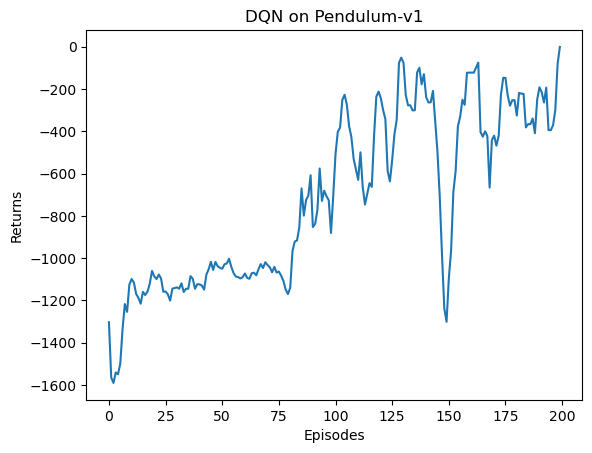

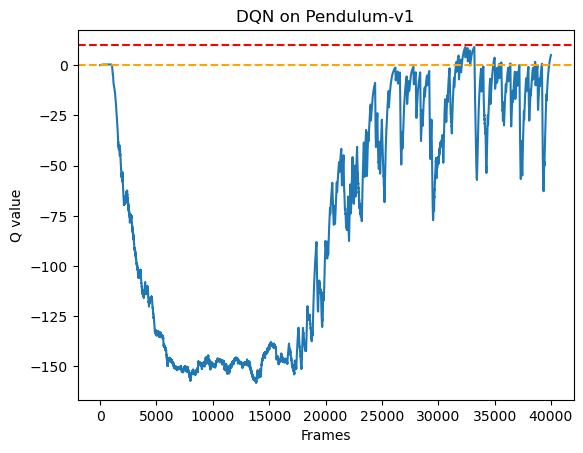

In [75]:
episodes_list = list(range(len(reward_list)))
mv_return = rl_utils.moving_average(reward_list, 5)

plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()

## üéâ ËØÑ‰ª∑

ÊúÄÂ§ßÂ•ñÂä±ÊòØ0Ôºå‰ΩÜÊòØQÂÄºÂ§öÊ¨°Â§ß‰∫é0ÔºåÁîöËá≥ÊúâÂà∞10ÁöÑÔºåÊòØÁî±argmaxÈÄâÊã©Âä®‰ΩúÈÄ†ÊàêÁöÑËøáÊãüÂêàÁöÑÊÉÖÂÜµÔºåDouble DQNÊîπÂñÑ‰∫ÜÊ≠§ÈóÆÈ¢ò„ÄÇ

Ê≠§Â§ñÂ§öÊ¨°QÂÄº‰Ωé‰∫é-50ÔºåËØ¥Êòé‰∏çÁ®≥ÂÆöÊÄßÂæàÂ§ßÔºåËÄåDouble DQN‰πüÊúâÊ≠§ÈóÆÈ¢òÔºåDueling DQNÂàôÊîπÂñÑ‰∫ÜÊ≠§ÈóÆÈ¢ò„ÄÇ

## ÊºîÁ§∫

In [51]:
def show_gym_policy(name, model, render_mode="human", epochs=10, steps=300):
    env = gym.make(name, render_mode=render_mode)
    env.reset()
    totals = []

    for i in range(epochs):  # ÊµãËØïËΩÆÊï∞
        episode_rewards = 0
        obs = env.reset()[0]  # Á¨¨‰∫å‰∏™ËæìÂá∫‰∏∫infoÔºåÂèØ‰ª•‰∏çË¶Å
        for _ in range(steps):  # ÊØèÂõûÂêàÊúÄÂ§ö300Ê≠•
            try:
                Q_values = model(torch.tensor(obs).to('cuda'))
                action = np.argmax(Q_values.tolist())
                obs, reward, done, truncated, info = env.step([dis_to_con(action, env, agent.action_dim)])
                episode_rewards += reward
            except:
                env.close()
            if done or truncated:
                break
        totals.append((episode_rewards))
    env.close()
    return totals

In [54]:
show_gym_policy(env_name, agent.q_net)

[-238.01666589170281,
 -127.97067787302136,
 -239.58886993548853,
 -517.6151866464927,
 -3.7420484544063317,
 -124.13917652548557,
 -126.06749475689074,
 -121.8245985928503,
 -4.762697646898301,
 -244.991032523696]

# ËÆ≠ÁªÉDouble DQN

In [77]:
CKP_PATH = 'checkpoints/ckpt_Double_dqn.pt'
read_ckp(CKP_PATH)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device, 'DoubleDQN')
reward_list, max_q_value_list = train_DQN(agent=agent, env=env, total_epoch=total_epoch, total_episode=total_episode,
                                          replay_buffer=replay_buffer, minimal_size=minimal_size,
                                          batch_size=batch_size)

## ‰ΩúÂõæ

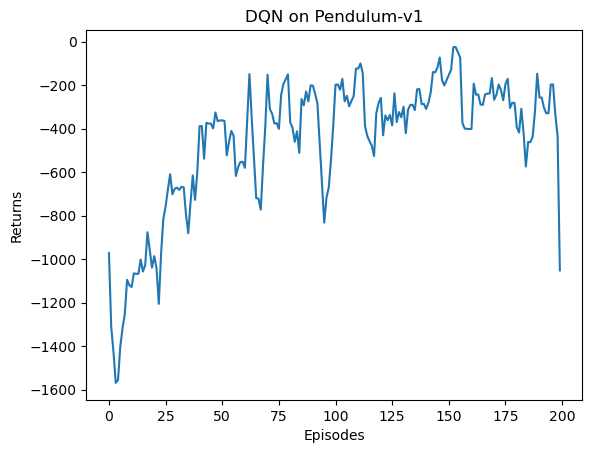

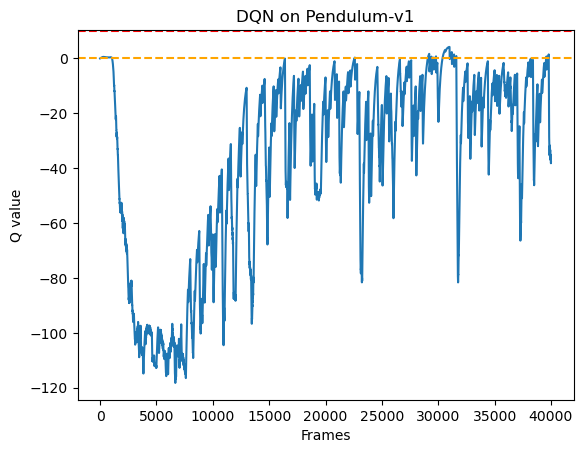

In [79]:
episodes_list = list(range(len(reward_list)))
mv_return = rl_utils.moving_average(reward_list, 5)

plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {} by avg_5'.format(env_name))
plt.show()

## üéâ ËØÑ‰ª∑

Double DQN‰∏≠Âä®‰ΩúÁöÑÈÄâÂèñ‰æùÈù†ÁõÆÊ†áÁΩëÁªúÔºåÁõÆÊ†áÁΩëÁªúÁöÑÂèÇÊï∞Êõ¥Êñ∞ÊúâÂª∂ËøüÔºåËÄåÂâçÈù¢ÂæóÂà∞ÁöÑÂä®‰ΩúÁöÑQÂÄºÁöÑ‰º∞ËÆ°ËøòÊòØ‰æùÊçÆÂéüÁΩëÁªúÔºåÊôÆÈÄöDQNÁöÑÂä®‰ΩúÊòØ‰ªéÂéüÁΩëÁªú‰∏≠ÈÄâÂèñÁöÑÔºå‰ºöÂØºËá¥‰∏ÄÁõ¥Á¥ØÁßØQÂÄºÊØîËæÉÈ´òÁöÑÂä®‰ΩúÁöÑQÂÄºÔºåÈÄ†Êàê‰º∞ËÆ°ÂÅèÈ´ò„ÄÇ

‰ΩÜÊòØDouble DQN‰πüÂ≠òÂú®ÊØîËæÉ‰∏•ÈáçÁöÑ‰∏çÁ®≥ÂÆöÔºåÊúâÊó∂ÂÄôQÂÄº‰ºöÂ§ßÂπÖ‰∏ãÈôçÔºåËøôÊòØÂõ†‰∏∫ÊØèÊ¨°Âè™Êõ¥Êñ∞‰∏ÄÁßçÁä∂ÊÄÅÂä®‰ΩúÁöÑQÂÄºÔºåËØ•Áä∂ÊÄÅ‰∏ãÂÖ∂‰ªñÂä®‰ΩúÁöÑQÂÄº‰∏çËÄÉËôëÔºåÊôÆÈÄöDQN‰πüÊúâÊ≠§ÈóÆÈ¢ò„ÄÇ

# ËÆ≠ÁªÉDueling DQN

In [100]:
CKP_PATH = 'checkpoints/ckpt_Dueling_dqn.pt'
read_ckp(CKP_PATH)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device, 'DuelingDQN')
reward_list, max_q_value_list = train_DQN(agent=agent, env=env, total_epoch=total_epoch, 
                                          total_episode=total_episode, replay_buffer=replay_buffer, minimal_size=minimal_size, batch_size=batch_size)

## ‰ΩúÂõæ

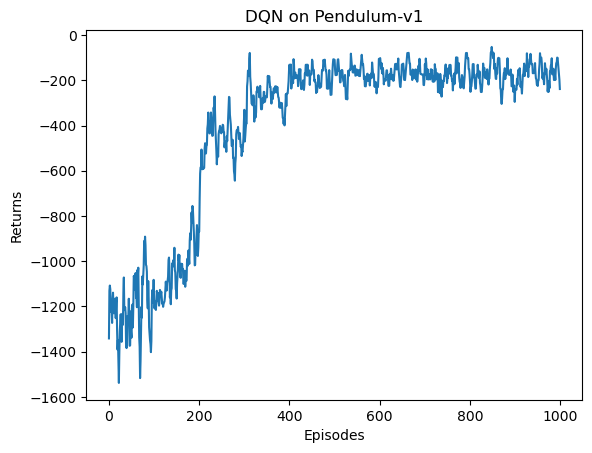

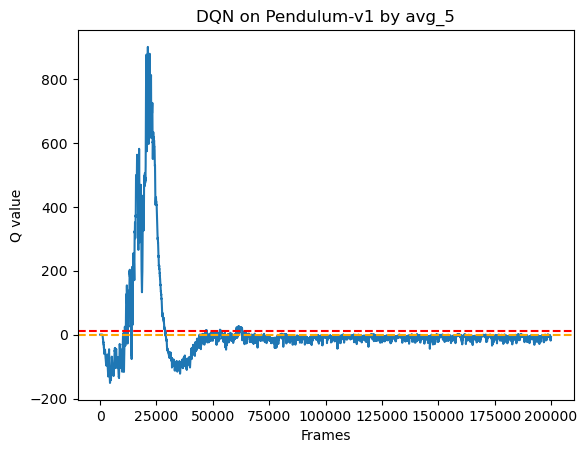

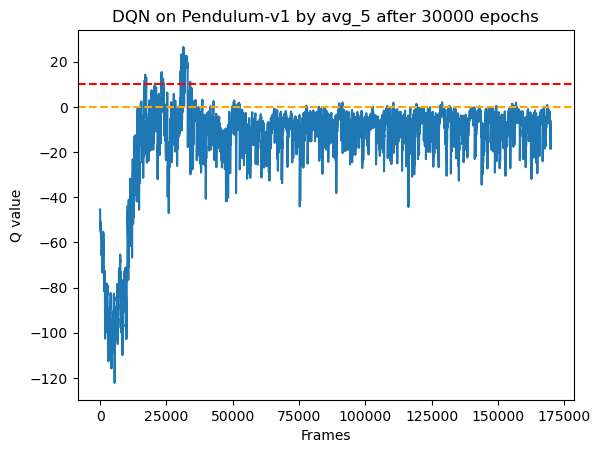

In [121]:
episodes_list = list(range(len(reward_list)))
mv_return = rl_utils.moving_average(reward_list, 5)

plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {} by avg_5'.format(env_name))
plt.show()



frames_list = list(range(len(max_q_value_list[30000:])))
plt.plot(frames_list, max_q_value_list[30000:])
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {} by avg_5 after 30000 epochs'.format(env_name))
plt.show()

## üéâ ËØÑ‰ª∑

Dueling DQNÁöÑÂ∑ÆÂºÇÂú®ÁΩëÁªú‰∏äÔºåÁΩëÁªúÂÖ±‰∫´‰∏ÄÂ•óÂèÇÊï∞ÔºàÈô§‰∫ÜÊúÄÂêéË¢´ÂàÜÂºÄÁöÑ‰∏ÄÂ±ÇÔºâ„ÄÇ

ÁΩëÁªúÊúâ‰∏§‰∏™ËæìÂá∫Ôºå‰∏Ä‰∏™ÊòØ‰ºòÂäøAÔºåÂè¶‰∏Ä‰∏™ÊòØÁä∂ÊÄÅ‰ª∑ÂÄºVÔºåÂÆûÈôÖ‰∏ä `A = Q - V`ÔºåÂç≥‰º∞ËÆ°ÁöÑQÂÄºÂáèÂéªÂΩìÂâçÁä∂ÊÄÅÁöÑ‰ª∑ÂÄºVÁ≠â‰∫éÂä®‰Ωú‰ºòÂäøAÔºå‰ΩÜÊòØÊàë‰ª¨ÈúÄË¶ÅÁΩëÁªúÁªôÂá∫QÂÄºÔºåÂõ†Ê≠§ÂèòÊàê `Q = V + A`. 
> Ê≥®ÔºöAÂíåQÊúâ‰∏§‰∏™ÂèÇÊï∞`s,a`ÔºåÊâÄ‰ª•Âè´`Áä∂ÊÄÅÂä®‰Ωú`‰ºòÂäø/‰ª∑ÂÄºÔºõVÂè™Êúâ‰∏Ä‰∏™ÂèÇÊï∞`s`ÔºåÊâÄ‰ª•Âè´`Áä∂ÊÄÅ`‰ª∑ÂÄº„ÄÇ

‰∏Ä‰∏™ÊòØVÂÄºÔºå‰ª£Ë°®ÂΩìÂâçÁä∂ÊÄÅÁöÑ‰ª∑ÂÄºÔºåÂ¶ÇÊûúÊòØ‰∏Ä‰∏™ÊâπÈáèÔºåÈÇ£‰πàÊúâ‰∏§‰∏™Áª¥Â∫¶ÔºåÂ§ßÂ∞èÊòØ(ÊâπÈáèÊï∞, 1)ÔºõÂè¶‰∏Ä‰∏™ÊòØAÔºåË°®Á§∫ÂΩìÂâçÂä®‰ΩúÁöÑÁõ∏ÂØπ‰ºòÂäøÔºà‰∫∫‰∏∫ÂÆö‰πâÁöÑÔºâÔºåÂÆÉÁ±ª‰ºº‰º†ÁªüÁöÑQÂÄºÔºåÂç≥ÁªôÂá∫‰∫ÜËØ•Áä∂ÊÄÅ‰∏ãÊØè‰∏™Âä®‰ΩúÁöÑQÂÄºÔºåÂ¶ÇÊûúËæìÂÖ•ÁöÑÊòØ‰∏Ä‰∏™ÊâπÈáèÔºåÈÇ£‰πàÂ§ßÂ∞èÊòØ(ÊâπÈáè, Âä®‰ΩúÁ©∫Èó¥)Ôºõ

Âú®ÁΩëÁªú‰∏≠ÈúÄË¶ÅÈôêÂà∂AÁöÑÊõ¥Êñ∞Ôºå$Q = V + (A - \bar{A})$, ÂáèÂéª$\bar{A}$Ôºå‰ºö‰ΩøÂæóAÊï¥‰ΩìÊõ¥Êé•Ëøë0ÔºåÂπ∂‰∏îÂùáÂÄº‰∏∫0ÔºåËøôÊòØ‰∏∫‰∫ÜÂáèÂ∞ëAÂú®Ê¢ØÂ∫¶‰∏ãÈôç‰∏≠ÁöÑË∞ÉÊï¥Â§ßÂ∞èÔºå‰ªéËÄå‰ΩøÂæóÊ¢ØÂ∫¶‰∏ãÈôç‰∏ªË¶ÅÂΩ±ÂìçVÔºåVÁöÑËæìÂá∫ÊØîËæÉÁÆÄÂçïÔºå‰πüÂ•ΩË∞ÉÊï¥‰∏Ä‰∫õÔºåËÄåÊîπÂèò‰∫ÜVÔºå‰πüÂ∞±ÂêåÊó∂ÊîπÂèò‰∫ÜÊâÄÊúâÂä®‰ΩúÁöÑAÂÄº(ËøêÁÆóÁöÑÂπøÊí≠Êú∫Âà∂)ÔºåÁ≠â‰∫éÊîπÂèò‰∫ÜÊâÄÊúâÂä®‰ΩúÁöÑQÂÄºÔºàÂêåÊó∂Â¢ûÂä†ÊàñËÄÖÂáèÂ∞ëÔºâÔºåÂõ†Ê≠§Âú®Êüê‰∏™Áä∂ÊÄÅ‰∏ãÁöÑÂ≠¶‰π†‰ºöÂØπÊâÄÊúâÂä®‰ΩúÁöÑ‰º∞ËÆ°‰∫ßÁîüÂΩ±ÂìçÔºåËÄå‰∏çÊòØÂè™ÊîπÂèòQÂÄºÊúÄÂ§ßÁöÑÈÇ£‰∏™Âä®‰ΩúÁöÑ‰º∞ËÆ°„ÄÇËøôÂ∞±Á±ª‰ºº‰∫é‰ªéÁä∂ÊÄÅ‰∏≠Â≠¶‰π†‰ª∑ÂÄºÔºåÊúâÁöÑÁä∂ÊÄÅÊØîËæÉÂ•ΩÔºåÁî®‰ªÄ‰πàÂä®‰ΩúÈÉΩËÉΩËé∑Âà©ÔºåÊúâÁöÑÁä∂ÊÄÅÊØîËæÉÂ∑ÆÔºåÂæàÂ§öÂä®‰ΩúÈÉΩ‰ºöÂèóÊçüÔºåÂ∞±ÂáèÂ∞èËØ•Áä∂ÊÄÅ‰∏ãÊâÄÊúâÂä®‰ΩúÁöÑQÂÄº„ÄÇ

Âú®ÂâçÈù¢ÁöÑÊôÆÈÄöDQNÂíåDouble DQN‰∏≠ÔºåÊ≤°ÊúâAÂíåVÁöÑÊ¶ÇÂøµÔºåÁΩëÁªúÁõ¥Êé•ËæìÂá∫QÔºåÂú®ÂèçÂêë‰º†Êí≠‰∏≠ÔºåÂè™ËÄÉËôë‰∫ÜQÂÄºÊúÄÂ§ßÁöÑÈÇ£‰∏™Âä®‰ΩúÔºåÂú®ÂèçÂêë‰º†Êí≠‰∏≠ÔºåÂ∞±Âè™ÊòØËÄÉËôë‰∫ÜËØ•Âä®‰ΩúÈÄ†ÊàêÁöÑËØØÂ∑Æ„ÄÇ